## A machine learning model exercise on HR Data available on Kaggle by Manoj Agrawal

https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

"A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses that are conducted by the same company. Company wants to know which of these candidates really want to work for the company after completing their training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment."

Features

enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix

from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score, GridSearchCV

from xgboost import XGBClassifier, plot_importance

## Read dataset into the notebook and explore 

In [163]:
df = pd.read_csv("aug_train.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

### Enrollee id is not needed for modeling so we can drop it from dataset

In [165]:
df.drop(['enrollee_id'], axis = 1, inplace=True)

### Explore the numerical data

In [166]:
df.describe()

,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


### Split the datset into train and test

In [167]:
df.sample(frac=1, random_state=10).reset_index(drop=True)
train, test = train_test_split(df, test_size=0.2,random_state=11)
print(train['target'].value_counts())
print(test['target'].value_counts())

0.0    11500
1.0     3826
Name: target, dtype: int64
0.0    2881
1.0     951
Name: target, dtype: int64


In [168]:
print(train['target'].sum()/len(train['target']))
print(test['target'].sum()/len(test['target']))

0.2496411327156466
0.2481732776617954


In [169]:
train_y = train['target']
test_y = test['target']
train_X = train.drop('target', axis=1)
test_X = test.drop('target', axis=1)
train_X.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
3215,city_21,0.624,Male,No relevent experience,no_enrollment,Graduate,STEM,5,10000+,Pvt Ltd,1,17
10438,city_103,0.920,Male,Has relevent experience,no_enrollment,Masters,STEM,20,10000+,Pvt Ltd,>4,22
14889,city_103,0.920,Male,No relevent experience,no_enrollment,Masters,Business Degree,11,10000+,Pvt Ltd,>4,12
3860,city_103,0.920,Male,No relevent experience,Full time course,Graduate,STEM,2,50-99,Pvt Ltd,1,48
17958,city_103,0.920,Male,Has relevent experience,Part time course,Graduate,STEM,4,1000-4999,Pvt Ltd,1,66


### Let's explore the numerical features for co-linearity 

In [171]:
train_X.corr()

,city_development_index,training_hours
city_development_index,1.000000,0.006851
training_hours,0.006851,1.000000


### Let's if there are any patterns in the numerical data

In [200]:
print(train[train['target']==1].city_development_index.mean())
print(train[train['target']==0].city_development_index.mean())

0.7550554103502263
0.8529577391304473


In [201]:
print(train[train['target']==1].training_hours.mean())
print(train[train['target']==0].training_hours.mean())

63.09592263460533
66.12052173913044


### Let's check the distribution

<function matplotlib.pyplot.show(close=None, block=None)>

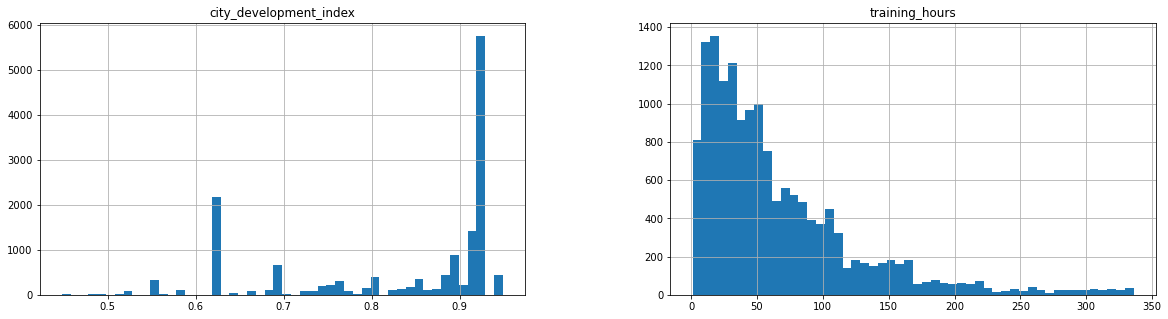

In [176]:
train_X.hist(bins=50,figsize=(20,5))
plt.show

### Lets use log transformation on 'training hours' and check the histograms

<function matplotlib.pyplot.show(close=None, block=None)>

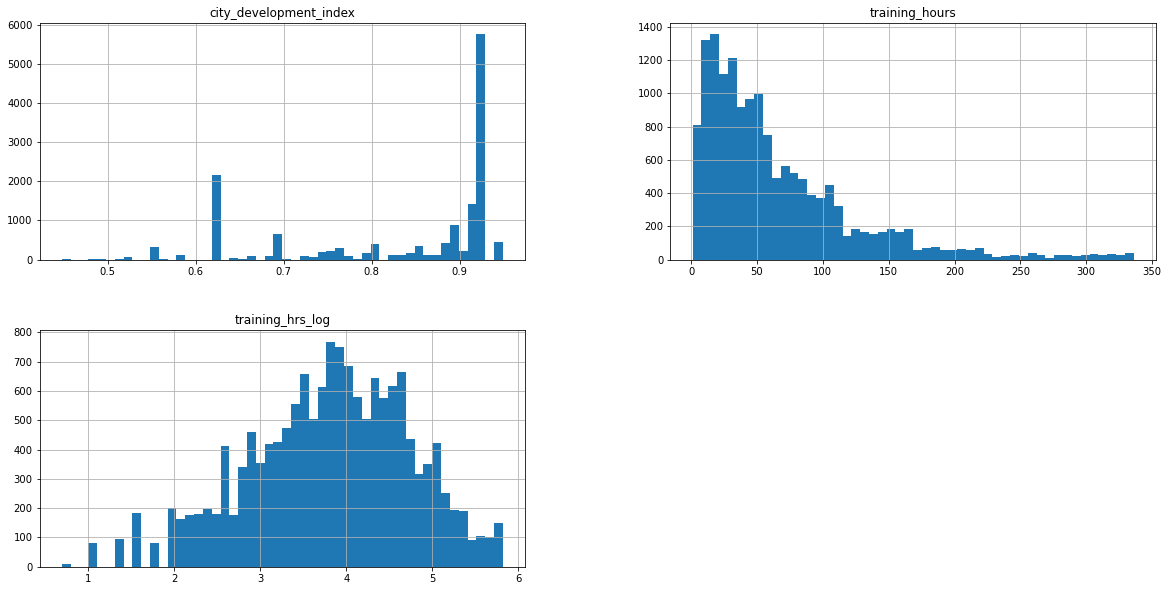

In [178]:
train_X['training_hrs_log'] = np.log1p(train_X['training_hours'])
train_X.hist(bins=50,figsize=(20,10))
plt.show

### This is better, we can do the same for test dataset and remove the training hours column

In [179]:
test_X['training_hrs_log'] = np.log1p(test_X['training_hours'])
train_X.drop('training_hours',axis = 1, inplace= True)
test_X.drop('training_hours',axis = 1, inplace= True)

### Let's explore some categorical features to see if there are any recognizable patterns

In [181]:
train[['target','gender']].groupby('gender').mean().sort_values(by='target', ascending = False)

,target
gender,
Female,0.269809
Other,0.231788
Male,0.226179


In [182]:
train[['target','company_size']].groupby('company_size').mean().sort_values(by='target', ascending = False)

,target
company_size,
10/49,0.237217
10000+,0.194581
5000-9999,0.179825
50-99,0.175888
500-999,0.175141
<10,0.168571
100-500,0.158554
1000-4999,0.150517


In [183]:
train[['target','company_type']].groupby('company_type').mean().sort_values(by='target', ascending = False)

,target
company_type,
Other,0.232323
Early Stage Startup,0.226611
Public Sector,0.212366
NGO,0.182898
Pvt Ltd,0.181899
Funded Startup,0.142327


In [184]:
train[['target','enrolled_university']].groupby('enrolled_university').mean().sort_values(by='target', ascending = False)

,target
enrolled_university,
Full time course,0.382187
Part time course,0.251331
no_enrollment,0.211306


In [185]:
train[['target','education_level']].groupby('education_level').mean().sort_values(by='target', ascending = False) 

,target
education_level,
Graduate,0.279271
Masters,0.222412
High School,0.190211
Phd,0.140187
Primary School,0.118577


In [186]:
train[['target','relevent_experience']].groupby('relevent_experience').mean().sort_values(by='target', ascending = False) 

,target
relevent_experience,
No relevent experience,0.334810
Has relevent experience,0.216544


<AxesSubplot:xlabel='gender'>

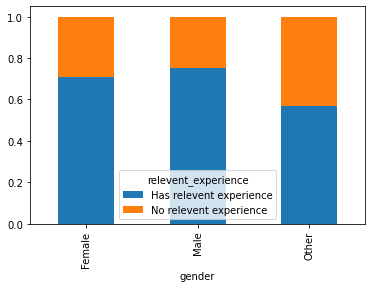

In [187]:
gender_cnts = pd.crosstab(train_X.gender, train_X.relevent_experience)
gender_pcts = gender_cnts.div(gender_cnts.sum(1).astype(float), axis=0)
gender_pcts.plot(kind='bar', stacked=True)

### check cardinality of categorical columns

In [189]:
object_cols = train_X.dtypes[train_X.dtypes=='object'].index.tolist()

# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('relevent_experience', 2),
 ('gender', 3),
 ('enrolled_university', 3),
 ('education_level', 5),
 ('major_discipline', 6),
 ('company_type', 6),
 ('last_new_job', 6),
 ('company_size', 8),
 ('experience', 22),
 ('city', 123)]

### City has 123 unique value so has high cardinality. Since we already have city development index we can remove column 'city' from the dataset.

### Experience has 22 unique values and has high cardinality. Let's look at that later

In [190]:
train_X.drop('city',axis = 1, inplace= True)
test_X.drop('city',axis = 1, inplace= True)

### Let's see what going on with 'Experience' column 

In [191]:
train_X['experience'].value_counts()

>20    2608
5      1136
4      1108
3      1099
6       989
2       908
7       856
10      780
9       776
8       633
15      554
11      540
14      453
1       440
12      415
16      415
<1      408
13      323
17      263
19      241
18      217
20      116
Name: experience, dtype: int64

### Function to create reduced number of categories for experience column

In [192]:
def ExperienceBuckets(X):
    X.loc[X['experience'] == '>20', 'experience'] = '22'
    X.loc[X['experience'] == '<1', 'experience'] = '0.5'
    X['experience'] = pd.to_numeric(X['experience'])
    
    conditions = [
    (X['experience'] <1),
    (X['experience'] <= 5),
    (X['experience'] > 5) & (X['experience'] <= 10),
    (X['experience'] > 10) & (X['experience'] <= 15),
    (X['experience'] > 15) & (X['experience'] <= 20),
    (X['experience'] >20)]
    
    # create a list of the values we want to assign for each condition
    #values = ['<1', '1-5', '5-10', '10-15', '15-20', '>20']
    values = [1, 2, 3, 4, 5, 6]
    
    # create a new column and use np.select to assign values to it using our lists as arguments
    X['experience_ord'] = np.select(conditions, values)
    return X


In [193]:
train_X = ExperienceBuckets(train_X)
test_X = ExperienceBuckets(test_X)
print(train_X.head())
print(test_X.head())

       city_development_index gender      relevent_experience  \
3215                    0.624   Male   No relevent experience   
10438                   0.920   Male  Has relevent experience   
14889                   0.920   Male   No relevent experience   
3860                    0.920   Male   No relevent experience   
17958                   0.920   Male  Has relevent experience   

      enrolled_university education_level major_discipline  experience  \
3215        no_enrollment        Graduate             STEM         5.0   
10438       no_enrollment         Masters             STEM        20.0   
14889       no_enrollment         Masters  Business Degree        11.0   
3860     Full time course        Graduate             STEM         2.0   
17958    Part time course        Graduate             STEM         4.0   

      company_size company_type last_new_job  training_hrs_log  experience_ord  
3215        10000+      Pvt Ltd            1          2.890372               2  
10

In [194]:
train_X.drop('experience', axis = 1, inplace = True)
test_X.drop('experience', axis = 1, inplace = True)

### We can convert education level category to numerical

In [195]:
train_X['education_level'].value_counts()

Graduate          9267
Masters           3507
High School       1614
Phd                321
Primary School     253
Name: education_level, dtype: int64

In [196]:
education_mapping = {"Primary School": 1, "High School": 2, "Graduate":3, "Masters": 4, "Phd":5}

In [204]:
train_X['education_level'] = train_X['education_level'].map(education_mapping)
test_X['education_level'] = test_X['education_level'].map(education_mapping)
train_X.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type,last_new_job,training_hrs_log,experience_ord
3215,0.624,Male,No relevent experience,no_enrollment,NaN,STEM,10000+,Pvt Ltd,1,2.890372,2
10438,0.920,Male,Has relevent experience,no_enrollment,NaN,STEM,10000+,Pvt Ltd,>4,3.135494,5
14889,0.920,Male,No relevent experience,no_enrollment,NaN,Business Degree,10000+,Pvt Ltd,>4,2.564949,4
3860,0.920,Male,No relevent experience,Full time course,NaN,STEM,50-99,Pvt Ltd,1,3.891820,2
17958,0.920,Male,Has relevent experience,Part time course,NaN,STEM,1000-4999,Pvt Ltd,1,4.204693,2


### Get the numeric and category coloumns

In [205]:
attribs = train_X.columns
num_attribs = list(train_X._get_numeric_data().columns)
cat_attribs = list(set(attribs) - set(num_attribs))
print(num_attribs)
print(cat_attribs)

['city_development_index', 'education_level', 'training_hrs_log', 'experience_ord']
['company_type', 'enrolled_university', 'gender', 'major_discipline', 'last_new_job', 'company_size', 'relevent_experience']


### Create DataFrame selector class


In [206]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

### Create pipelines for numerical and category columns

In [207]:
num_pipeline = Pipeline([('Selector', DataFrameSelector(num_attribs)), ('imputer',SimpleImputer(strategy='median')),\
                        ('std_scaler',StandardScaler())])

cat_pipeline = Pipeline([('Selector', DataFrameSelector(cat_attribs)), ('category_imputer',SimpleImputer(strategy='constant',fill_value="unknown")),\
                                                 ('one_hot_encoder',OneHotEncoder(drop="if_binary"))])

### Complete pipeline

In [208]:
full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),("cat_pipeline", cat_pipeline)])

### prepare the training set by fitting and transforming using the complete pipeline

In [209]:
train_prepared = full_pipeline.fit_transform(train_X)
train_prepared

<15326x42 sparse matrix of type '<class 'numpy.float64'>'
	with 142223 stored elements in Compressed Sparse Row format>

In [222]:
test_prepared = full_pipeline.transform(test_X)
test_prepared

<3832x42 sparse matrix of type '<class 'numpy.float64'>'
	with 35565 stored elements in Compressed Sparse Row format>

## Training a logistic regression model

In [223]:
log_reg = LogisticRegressionCV(cv=10,max_iter=1000, class_weight={0:1,1:3}).fit(train_prepared, train_y)

In [224]:
def model_performance(model):
    predictions = model.predict(train_prepared)
    print('model: ',model)
    print('accuracy on training data: ', model.score(train_prepared, train_y))
    print('AUC on training data: ', roc_auc_score(train_y,predictions))
    
    predictions_test = model.predict(test_prepared)
    
    print('accuracy on test data: ', model.score(test_prepared, test_y))
    print('AUC on test data: ',roc_auc_score(test_y,predictions_test))
    
    print(confusion_matrix(predictions_test, test_y))

In [225]:
model_performance(log_reg)

model:  LogisticRegressionCV(class_weight={0: 1, 1: 3}, cv=10, max_iter=1000)
accuracy on training data:  0.7308495367349602
AUC on training data:  0.740509375213073
accuracy on test data:  0.7223382045929019
AUC on test data:  0.7308111339714018
[[2057  240]
 [ 824  711]]


### Model is just about okay. Lets check the learning curves. This is standard code provided on sklearn website

In [242]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

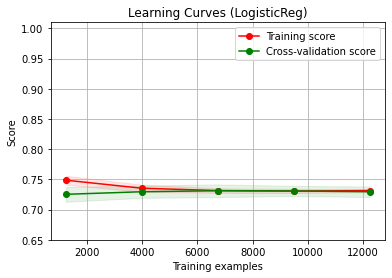

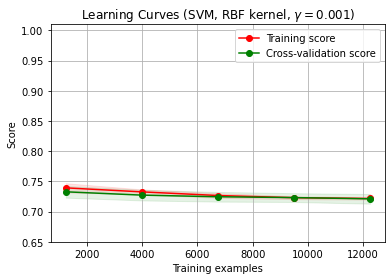

In [244]:
title = "Learning Curves (LogisticReg)"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = LogisticRegression(class_weight={0:1,1:3})
plot_learning_curve(estimator, title, train_prepared, train_y, ylim=(0.65, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001,class_weight={0:1,1:3})
plot_learning_curve(estimator, title, train_prepared, train_y, (0.65, 1.01), cv=cv, n_jobs=4)

plt.show()

### Both models are underfitting but Logistic regression performs slightly better. Adding more data will not help. 

### Let's try Random Forest with cross validation

In [141]:
rf = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=0, class_weight={0:1,1:3})
print(np.mean(cross_val_score(rf, train_prepared, train_y, cv=5)))

0.7716952653371344


### Accuracy is better but let's re-try with hyper parameter tuning

In [142]:
param_grid = {'n_estimators': [100,200,300],'max_depth': [15,20,30]}

In [143]:
rf = RandomForestClassifier(random_state=0, class_weight={0:1,1:3})
grid_rf = GridSearchCV(rf, param_grid, cv=10)
grid_rf.fit(train_prepared, train_y)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 3},
                                              random_state=0),
             param_grid={'max_depth': [15, 20, 30],
                         'n_estimators': [100, 200, 300]})

In [144]:
grid_rf.best_params_

{'max_depth': 20, 'n_estimators': 100}

In [145]:
best_grid_rf = grid_rf.best_estimator_
model_performance(best_grid_rf)

model:  RandomForestClassifier(class_weight={0: 1, 1: 3}, max_depth=20, random_state=0)
accuracy on training data:  0.9389925616599243
AUC on training data:  0.9354532375735812
accuracy on test data:  0.7802713987473904
AUC on test data:  0.712281158947395
[[2441  402]
 [ 440  549]]


### Random Forest performs well on training data but doesn't generalize well on test data. Accuracy is better than Logistic Regression but AUC is lower.

### Let's try Extreme gradiant boosing as our final model

In [146]:
xgb_model = XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.002, \
                          use_label_encoder=False, scale_pos_weight=3).fit(train_prepared, train_y)

[14:33:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [147]:
model_performance(xgb_model)

model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.002, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
accuracy on training data:  0.8131932663447736
AUC on training data:  0.8077622673242573
accuracy on test data:  0.7721816283924844
AUC on test data:  0.749166463186963
[[2290  282]
 [ 591  669]]


### This is an better model. We can simplify the model a little so that it generalizes better on the test data

In [151]:
xgb_model_simple = XGBClassifier(max_depth=8, n_estimators=50, learning_rate=0.05, use_label_encoder=False,scale_pos_weight=3).fit(train_prepared, train_y)

[14:35:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [152]:
model_performance(xgb_model_simple)

model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
accuracy on training data:  0.8148897298708078
AUC on training data:  0.8078462237778132
accuracy on test data:  0.7834029227557411
AUC on test data:  0.7615601108243537
[[2319  268]
 [ 562  683]]


### This is a much better model with higher accuracy rate as well as better AUC than the previous. This is a good model considering limited features.

### Let's check feature importance

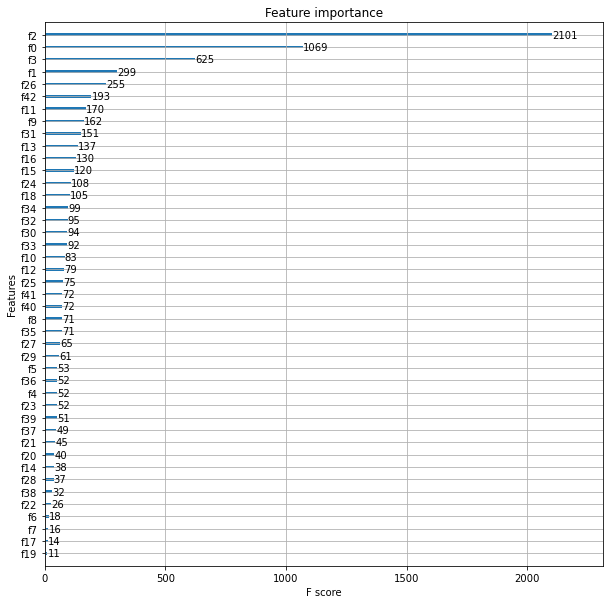

In [227]:
ax = plot_importance(xgb_model_simple)
fig = ax.figure
fig.set_size_inches(10, 10)

### Training hours and city development index are the best predictors followed by total experience

### What we have is a decent but not a great model. 

### We can try to improve the performance by using voting classifiers or stacking that would combine various individual classifiers to may give better results. 

### Let's try stacking

In [244]:
log_reg = LogisticRegression(max_iter=1000, class_weight={0:1,1:3})
rf = RandomForestClassifier(n_estimators=100,max_depth=20,random_state=0, class_weight={0:1,1:3})
xgb = XGBClassifier(max_depth=8, n_estimators=50, learning_rate=0.05, use_label_encoder=False,scale_pos_weight=3)
svc = SVC(gamma=0.001,class_weight={0:1,1:3})
classifiers = [('svc', svc), 
               ('rf', rf),                             
               ('log_reg', log_reg)]

In [245]:
clf = StackingClassifier(estimators=classifiers, 
                         final_estimator=xgb,
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False)

In [246]:
clf.fit(train_prepared,train_y)

[13:56:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingClassifier(estimators=[('svc',
                                SVC(class_weight={0: 1, 1: 3}, gamma=0.001)),
                               ('rf',
                                RandomForestClassifier(class_weight={0: 1,
                                                                     1: 3},
                                                       max_depth=20,
                                                       random_state=0)),
                               ('log_reg',
                                LogisticRegression(class_weight={0: 1, 1: 3},
                                                   max_iter=1000))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytre...
                                                 interaction_constrai

In [247]:
model_performance(clf)

model:  StackingClassifier(estimators=[('svc',
                                SVC(class_weight={0: 1, 1: 3}, gamma=0.001)),
                               ('rf',
                                RandomForestClassifier(class_weight={0: 1,
                                                                     1: 3},
                                                       max_depth=20,
                                                       random_state=0)),
                               ('log_reg',
                                LogisticRegression(class_weight={0: 1, 1: 3},
                                                   max_iter=1000))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytre...
                                                 interaction_

#### Stacking did not help. We can play around with hyper parameters and with 'base estimators and final classifier' combination to see if performance improves, however, I do not expect a lot of improvement because some very important features such as employee satisfaction survey data, employee performance data, manager data, time since last promotion etc. missing, that might be better predictors.